# Logistic Regression for Gene Expression Data


The data in this lab comes from:

https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression

In this data, mice were characterized by three properties:
* Whether they had down's syndrome (trisomy) or not
* Whether they were stimulated to learn or not
* Whether they had a drug memantine or a saline control solution.

With these three choices, there are 8 possible classes for each mouse.  For each mouse, the expression levels were measured across 77 genes.  


## Load the Data

In [23]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

In [24]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00342/'+
                 'Data_Cortex_Nuclear.xls', index_col=0)
df.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


In [25]:
df1 = df.fillna(df.mean())

## Binary Classification for Down's Syndrome

We will first predict the binary class label in `df1['Genotype']` which indicates if the mouse has Down's syndrome or not.

In [26]:
ystr = df1['Genotype'].values
vals, y = np.unique(ystr, return_inverse=True)

In [27]:
xnames = df1.columns[:-4]
X = np.array(df1[xnames].values) #standardizing the data matrix
Xs = preprocessing.scale(X)

In [28]:
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(Xs,y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [29]:
yhat = logreg.predict(Xs)
acc = np.mean(yhat == y) # measuring the accuracy
print('Accuracy on the training data is {0:f}'.format(acc))

Accuracy on the training data is 1.000000


The accuracy is high since we are fitting the model on the same data that we are predicting. (train data)

## Interpreting the weight vector

<Container object of 3 artists>

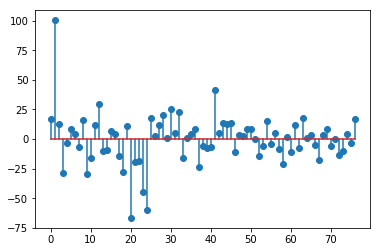

In [30]:
W = logreg.coef_
W = W.ravel()
plt.stem(W)

`W[i]` is very large for a few components `i`, these are the genes that are likely to be most involved in Down's Syndrome.    

In [31]:
ind = np.argsort(np.abs(W))

i1 = ind[-1]    # largest element
i2 = ind[-2]    # second largest element

name1 = xnames[i1]
name2 = xnames[i2]
print('The two most significant genes are {0:s} and {1:s}'.format(name1,name2))

The two most significant genes are ITSN1_N and BRAF_N


## Cross Validation

Finding the accuracy on the test data.

In [32]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
prec = []
rec = []
f1 = []
err_rate = []

for Itr, Its in kf.split(Xs):
            
    # Get training and test data
    Xtr = Xs[Itr,:]
    ytr = y[Itr]
    Xts = Xs[Its,:]
    yts = y[Its]
    
    # Fit a model
    logreg.fit(Xtr, ytr)
    
    # Predict the labels on the test data
    yhat = logreg.predict(Xts)
    
    # precision, recall and f1-score.
    preci,reci,f1i,_= precision_recall_fscore_support(yts,yhat,average='binary') 
    prec.append(preci)
    rec.append(reci)
    f1.append(f1i)
    err_rate.append(np.mean(yts != yhat))

# Take the mean performance metrics over the different folds.
prec = np.mean(prec)
rec = np.mean(rec)
f1 = np.mean(f1)
err_mean = np.mean(err_rate)

print('Precision =  {0:.4f}'.format(prec))
print('Recall =     {0:.4f}'.format(rec))
print('f1 =         {0:.4f}'.format(f1))
print('error rate = {0:.4f}'.format(err_mean))

Precision =  0.9620
Recall =     0.9490
f1 =         0.9549
error rate = 0.0426


## Multi-Class Classification

In [33]:
ystr = df1['class'].values
vals, y = np.unique(ystr, return_inverse=True)

In [34]:
logreg = linear_model.LogisticRegression()
logreg.fit(Xs,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
yhat = logreg.predict(Xs)
acc = np.mean(yhat == y)
print('Accuracy on the training data is {0:f}'.format(acc))

Accuracy on the training data is 0.999074


The confusion matrix counts across all folds and then normalize the rows of the confusion matrix so that they sum to one.  Thus, each element `C[i,j]` will represent the fraction of samples where `yhat==j` given `ytrue==i`.  

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

logreg = linear_model.LogisticRegression()

# Initialize the confusion matrix counts
ny = np.max(y)
C = np.zeros((ny+1,ny+1))

# Create the cross-validation object
nfold = 10
kf = KFold(n_splits=nfold, shuffle=True)
err_rate = np.zeros(nfold)

# Loop over the folds in the cross-validation
for ifold, Ind in enumerate(kf.split(Xs)):
                
    # Get training and test data
    Itr, Its = Ind
    Xtr = Xs[Itr,:]
    ytr = y[Itr]
    Xts = Xs[Its,:]
    yts = y[Its]
    
    # Fit a model
    logreg.fit(Xtr, ytr)
    
    # Predict the labels on the test set.
    yhat = logreg.predict(Xts)
    
    # Add the counts to the confusion matrix 
    # and store the error rate
    C += confusion_matrix(yts,yhat)
    err_rate[ifold] = np.mean(yhat != yts)    
    
# Normalize the confusion matrix
Csum = np.sum(C,1)
C = C / Csum[np.newaxis,:]

# Print the confusion matrix
print(np.array_str(C, precision=4, suppress_small=True))

# Print the overall error rate
err_mean = np.mean(err_rate)
err_se = np.std(err_rate)/np.sqrt(nfold-1)
print("Error rate = %12.4e, SE=%12.4e" % (err_mean,err_se))

[[0.9733 0.0074 0.0067 0.     0.0148 0.     0.     0.    ]
 [0.     0.9852 0.     0.     0.0074 0.0095 0.     0.    ]
 [0.     0.     0.9933 0.     0.     0.     0.     0.0074]
 [0.0067 0.     0.     0.9852 0.0074 0.     0.     0.    ]
 [0.0067 0.0074 0.     0.     0.9852 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]
Error rate =   1.0185e-02, SE=  2.9117e-03


<Container object of 3 artists>

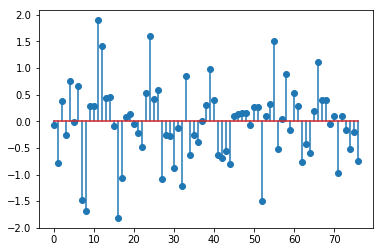

In [37]:
logreg = linear_model.LogisticRegression()
logreg.fit(Xs,y)
W = logreg.coef_

plt.stem(W[0,:])

## Using L1-Regularization (LASSO regularization with logistic regression)

In [38]:
# Penalty values to test
npen = 20
C_test = np.logspace(-1,3,npen)

# Create the cross-validation object and error rate matrix
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
err_rate = np.zeros((npen,nfold))

# Create the logistic regression object
logreg = linear_model.LogisticRegression(penalty='l1',warm_start=True)

# Loop over the folds in the cross-validation
for ifold, Ind in enumerate(kf.split(Xs)):        
            
    # Get training and test data
    Itr, Its = Ind
    Xtr = Xs[Itr,:]
    ytr = y[Itr]
    Xts = Xs[Its,:]
    yts = y[Its]
    
    # Loop over penalty levels
    for ipen, c in enumerate(C_test):
        
        # Set the penalty level        
        logreg.C= c
    
        # Fit a model on the training data
        logreg.fit(Xtr, ytr)
    
        # Predict the labels on the test set.
        yhat = logreg.predict(Xts)
        
        # Measure the accuracy
        err_rate[ipen,ifold] = np.mean(yhat != yts)
    
    print("Fold %d" % ifold)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


The minimum test error rate =   7.4074e-03, SE=  1.8519e-03


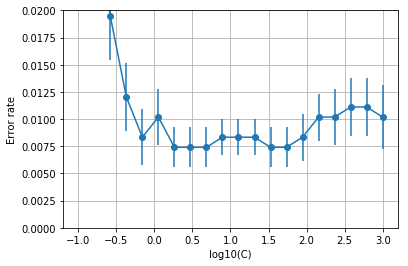

In [39]:
err_mean = np.mean(err_rate, axis=1)
err_se = np.std(err_rate,axis=1)/np.sqrt(nfold-1)
plt.errorbar(np.log10(C_test), err_mean, marker='o',yerr=err_se)
plt.ylim([0,0.02])
plt.grid()
plt.xlabel('log10(C)')
plt.ylabel('Error rate')

imin = np.argmin(err_mean)
print("The minimum test error rate = %12.4e, SE=%12.4e" % (err_mean[imin], err_se[imin]))

We see that the minimum error rate is significantly below the classifier that did not use the l1-penalty.  We will conclude by using the one SE rule to select an optimal `C`.

In [40]:
err_tgt = err_mean[imin] + err_se[imin]
iopt = np.where(err_mean < err_tgt)[0][0]
C_opt = C_test[iopt]

print("Optimal C=%12.4e" % C_opt)

Optimal C=  6.9519e-01


For the optimal `C`, fit the model on the entire training data with l1 regularization. Finding the resulting weight matrix, `W_l1`.  

Then we can plot the first row of this weight matrix and compare it to the first row of the weight matrix without the regularization.  

Text(0.5,1,'l1-regularization')

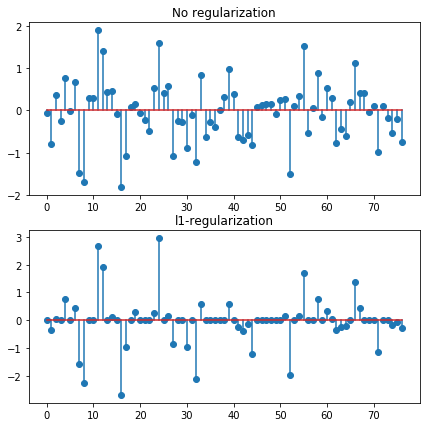

In [41]:
logreg = linear_model.LogisticRegression(C=C_opt,penalty='l1')
logreg.C= C_opt
logreg.fit(Xs,y)

W_l1 = logreg.coef_

plt.figure(figsize=(7,7))
plt.subplot(2,1,1)
plt.stem(W[0,:])
plt.title('No regularization')
plt.subplot(2,1,2)
plt.stem(W_l1[0,:])
plt.title('l1-regularization')

With l1-regularization, the weight matrix is much more sparse and hence the roles of particular genes are more clearly visible.